# Autocodificadores

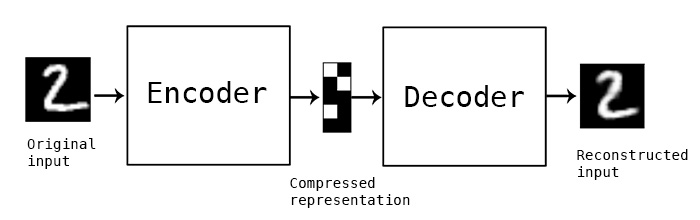

O autoencoder é uma estrutura de rede neural que é usada para codificar dados de forma eficiente. O primeiro bloco, o encoder, é responsável por aprender uma forma eficiente de reduzir a dimensionalidade do espaço de entrada. O segundo bloco, o decoder, é responsável em reconstruir o dado original a partir deste espaço reduzido de forma mais eficiente possível.

In [181]:
%matplotlib inline
import matplotlib.pylab as plot
import sys, os
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from IPython import display
from torch.autograd import Variable
from torch import np
import copy


## Carregamento do MNIST dataset (já está no disco)

In [182]:
data_train = torchvision.datasets.MNIST('/data/datasets/mnist_pytorch/', train=True)
data_test  = torchvision.datasets.MNIST('/data/datasets/mnist_pytorch/', train=False)

X_train = data_train.train_data.type(torch.FloatTensor) / 255.
X_train = X_train.view(-1,28*28)
Y_train = data_train.train_labels.type(torch.LongTensor)
X_test = data_test.test_data.type(torch.FloatTensor) / 255.
X_test = X_test.view(-1,28*28)
Y_test = data_test.test_labels.type(torch.LongTensor)

## Poucos dados?

In [183]:
poucos_dados = False;
if poucos_dados:
    X_train = X_train[:5000]
    Y_train = Y_train[:5000]
    X_test = X_test[:500]
    Y_test = Y_test[:500]

In [184]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

torch.Size([60000, 784]) torch.Size([60000]) torch.Size([10000, 784]) torch.Size([10000])


# DataLoaders

In [185]:
#x e y são os mesmos
trainset = torch.utils.data.TensorDataset(X_train, Y_train)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=50,
                                          shuffle=True,
                                          num_workers=2)

testset = torch.utils.data.TensorDataset(X_test, Y_test)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=50,
                                         shuffle=False,
                                         num_workers=2)

# Modelando a rede

In [186]:
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512,128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128,2)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 28*28, bias=True),
        )

    def forward(self,x):
        return self.decoder(self.encoder(x))
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

net = Net()
print(net)

Net (
  (encoder): Sequential (
    (0): Linear (784 -> 512)
    (1): ReLU ()
    (2): Linear (512 -> 128)
    (3): ReLU ()
    (4): Linear (128 -> 2)
  )
  (decoder): Sequential (
    (0): Linear (2 -> 128)
    (1): ReLU ()
    (2): Linear (128 -> 512)
    (3): ReLU ()
    (4): Linear (512 -> 784)
  )
)


## Códigos de apoio ao treinamento

In [187]:
def train(model, train_loader, test_loader, epochs, patience):
    
    last_epoch = 0
    last_loss = 0
    best_loss = 0
    patience_count = 0
    best_model = []
    loss_fn = torch.nn.MSELoss() #MSE pois não é problema de classificação
    optimizer = torch.optim.Adam(model.parameters())

    history_loss = np.empty(epochs)

    for t in range(epochs):
        print('Epoch {}/{}'.format(t, epochs - 1))
        print('-' * 10)

        for k, data in enumerate(train_loader):
            sys.stdout.write('%d/%d mini-batch\r' % (k,len(train_loader)))
            inputs, _ = data
            inputs = Variable(inputs)

            # Forward pass
            predict = model(inputs)

            # Compute and print loss.
            loss = loss_fn(predict, inputs)

            # Zero Gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()

            # Step
            optimizer.step()

        history_loss[t] = last_loss = loss.data[0]
        print('Epoch:', t, 'train loss:', last_loss)

        #Early stopping
        if(best_loss < last_loss):
            patience_count = 0
            best_loss = last_loss
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            last_epoch = t
            model = best_model
            break;

        patience_count += 1

    print('Done!')
    
    return model, history_loss[:last_epoch]

# Treinamento

In [188]:
epochs = 2
patience = 5

try:
    model, history_loss = train(net, trainloader, testloader, epochs, patience)
except KeyboardInterrupt:
    print('\nInterrupted!\n')


Epoch 0/1
----------
Epoch: 0 train loss: 0.04255402460694313
Epoch 1/1
----------
Epoch: 1 train loss: 0.03944021835923195
Done!


# Mostrando as entradas e saídas do autoencoder para um subconjunto qualquer dos dados de teste

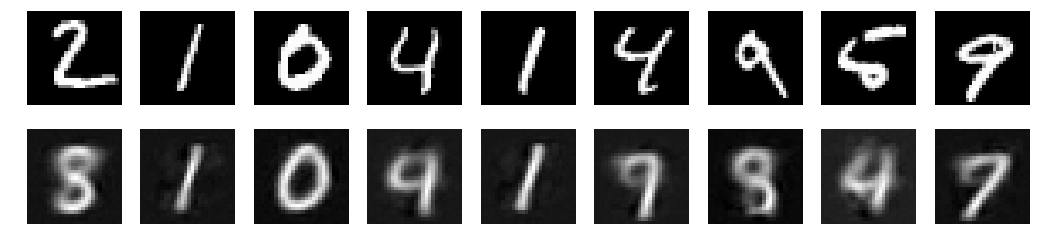

In [189]:
inputs, _ = next(testloader.__iter__())
n = 10

plot.figure(figsize=(20, 4))
plot.gray()
for i in range(1,n):
    # display original
    imgs = inputs[i].numpy().reshape(28,28)
    ax = plot.subplot(2, n, i)
    plot.imshow(imgs)
    plot.axis('off')

    # display reconstruction
    decoded_imgs = model(Variable(inputs[i])).data.numpy().reshape(28, 28)    
    ax = plot.subplot(2, n, i + n)
    plot.imshow(decoded_imgs)
    plot.axis('off')
plot.show()

# Plotando o espaço bidimensional. A reta a ser percorrida começa de (-2,-2) e termina em (1,1)

(10000, 2) (10000,)


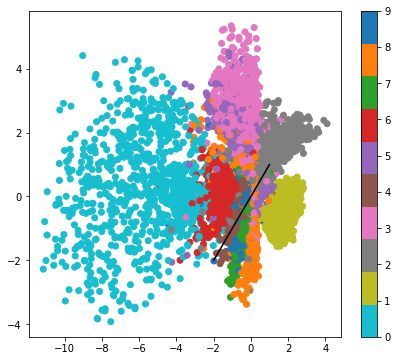

In [195]:
x_test_encoded = model.encoder(Variable(X_test)).data.numpy()
print(x_test_encoded.shape, Y_test.numpy().shape)

plot.figure(figsize=(7, 6))
plot.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=Y_test.numpy(), cmap=plot.cm.Vega10_r)

n = 10
l = np.linspace(-2,1,n)
plot.plot(l, l, color='k')
plot.colorbar();

# Plotando as saídas respectivas às entradas no espaço da reta

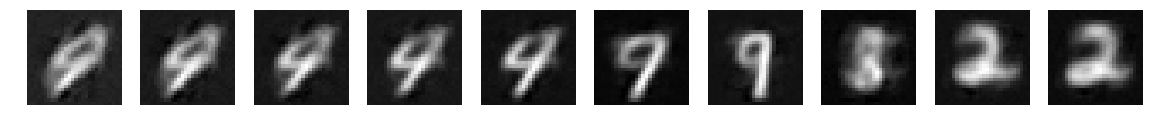

In [201]:
z = torch.from_numpy(np.column_stack((l, l))).type(torch.FloatTensor)

decoded_imgs = model.decode(Variable(z)).data.numpy().reshape(-1, 28, 28)

plot.figure(figsize=(20, 4))
plot.gray()
for i in range(0,n):
    ax = plot.subplot(1, n, i+1)
    plot.imshow(decoded_imgs[i])
    plot.axis('off')
plot.show()
    